# Sample Clarius Analysis

# Create raw from tar files

In [2]:
from pyquantus.parse.clarius import ClariusTarUnpacker

path = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213.tar'
extraction_mode = "single_tar"  # "single_sample", "multiple_samples", "single_tar"

ClariusTarUnpacker(path, extraction_mode) 

2025-03-12 17:21:43,072 - INFO - Deleted folder: /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted
2025-03-12 17:21:43,135 - INFO - Extracted '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213.tar' into '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted'
2025-03-12 17:21:43,136 - INFO - Searching for extracted folders...
2025-03-12 17:21:43,136 - INFO - Found extracted folder: /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted
2025-03-12 17:21:43,137 - INFO - Total extracted folders found: 1
2025-03-12 17:21:43,137 - INFO - Starting to search for LZO files inside extracted folders...
2025-03-12 17:21:43,137 - INFO - Found LZO file: /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_env.raw.lzo
2025-03-12 17:21:43,137 - INF

# Select Image & Phantom and Parse

In [3]:
from pyquantus.parse.clarius import clariusRfParser

rf_path = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_rf.raw'
rf_tgc_path = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_env.tgc.yml'
info_path = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_rf.yml'

imgData, imgInfo, refData, refInfo, scanConverted = clariusRfParser(rf_path, rf_tgc_path, info_path,
                                                       rf_path, rf_tgc_path, info_path) # image = phantom for now

Error loading YAML file: 'list' object has no attribute 'get'
Error loading YAML file: 'list' object has no attribute 'get'
The number of missing timestamps for /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_env.tgc.yml is: 31. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 31) is generated.
A default TGC matrix of size (192, 2928, 31) is generated.


100%|██████████| 31/31 [00:35<00:00,  1.15s/it]


The number of missing timestamps for /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/PDG1738089148213_extracted/2025-01-28T18-45-21+0000_env.tgc.yml is: 31. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 31) is generated.
A default TGC matrix of size (192, 2928, 31) is generated.


100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


# ROI Selection (from GUI)

In [4]:
import pickle

pkl_name = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Clarius RF/a896ef50-1922-4df2-8995-a57b5a46d800/roi.pkl'

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

In [5]:
from pathlib import Path

assert roi_info['Image Name'] == Path(rf_path).name
assert roi_info['Phantom Name'] == Path(rf_path).name

In [6]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [7]:
from pyquantus.utc import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [0, 8000000] # [min, max] (Hz)
config.analysisFreqBand = [2000000, 6000000] # [lower, upper] (Hz)
config.samplingFrequency = 15000000 # Hz
config.axWinSize = 3.85 # axial length per window (mm)
config.latWinSize = 3.85 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 3000000 # Hz

# UTC Analysis

In [8]:
from pyquantus.utc import UltrasoundImage

frame = 0

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [9]:
from pyquantus.utc import UtcAnalysis

utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.initAnalysisConfig()
utcAnalysis.scSplineX = scSplineX
utcAnalysis.scSplineY = scSplineY

In [10]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [12]:
utcAnalysis.splineToPreSc()
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows();

In [13]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis.attenuationCoef, "dB/cm/MHz")
print("Backscatter Coefficient:", utcAnalysis.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "µm") 
print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

Average Midband Fit: 0.0 dB
Average Spectral Slope: 0.0 dB/MHz
Average Spectral Intercept: 0.0 dB
Attenuation Coefficient: 0.5 dB/cm/MHz
Backscatter Coefficient: 0.01 1/cm-sr
w Nakagami Parameter: 50196.39130843499
u Nakagami Parameter: 1.1925533517873792
Effective Scatterer Diameter: 0.17673598070839378 µm
Effective Scatterer Concentration: 167.10417712573096 dB/mm^3


# Visualizations

In [14]:
from pyquantus.utc import UtcData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

utcData = UtcData()
utcData.utcAnalysis = utcAnalysis
utcData.scConfig = scConfig

In [15]:
utcData.convertImagesToRGB()

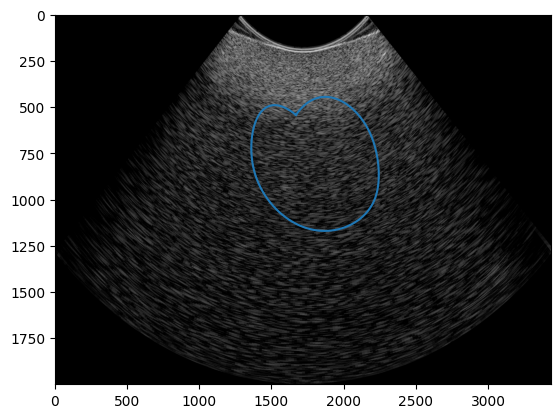

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(utcData.scBmode, aspect='auto')
plt.plot(scSplineX, scSplineY);

In [18]:
utcData.drawCmaps()
utcData.scanConvertCmaps()

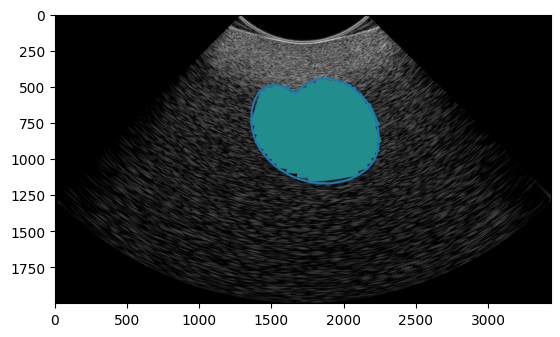

In [23]:
# Note cmap is solid as image = phantom in this case
plt.imshow(utcData.scMbfIm)
plt.plot(scSplineX, scSplineY);